In [6]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [7]:
import numpy as np
from lambeq import BobcatParser
from discopy import grammar
from discopy import Dim
from lambeq import AtomicType, IQPAnsatz, remove_cups
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset
import matplotlib.pyplot as plt

In [8]:
BATCH_SIZE =42
EPOCHS = 100
SEED = 2

In [9]:
#Input data
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences

In [10]:
train_labels, train_data = read_data('train_data.txt')

val_labels, val_data = read_data('val_data.txt')

In [11]:
#Parser
parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [12]:
train_diagrams = [
    diagram.normal_form()
    for diagram in train_diagrams if diagram is not None]
val_diagrams = [
    diagram.normal_form()
    for diagram in val_diagrams if diagram is not None]

train_labels = [
    label for (diagram, label)
    in zip(train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(val_diagrams, val_labels)
    if diagram is not None]


In [13]:
#Circuits
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

#train_circuits[0].draw(figsize=(9, 10))

In [14]:
#Model
all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)


In [15]:
#Loss & eval metrics
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}


In [16]:
#Trainer
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)


In [17]:
#Create dataset
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [18]:
#Train model
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=100)


Epoch 1:    train/loss: 6.4781   valid/loss: 2.9983   train/acc: 0.3750   valid/acc: 0.5625
Epoch 100:  train/loss: 0.3379   valid/loss: 0.4584   train/acc: 0.8750   valid/acc: 0.7500

Training completed!


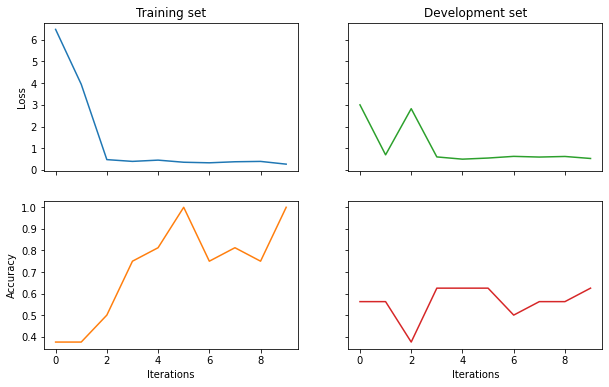

In [19]:
#Printing train model
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))


In [20]:
# print test accuracy
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())

Validation accuracy: 0.75
